In [1]:
import re #pacchetto per espressioni regolari
import os #pacchetto per muoversi nelle cartelle
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')  # Add parent directory to the Python path
from utils.helpers import *


In [2]:
# Carica file conllu
conllu_dir = 'data/profiling_output/13854/'

In [3]:
# Ottieni tutti i documenti
all_documents = []
for file_name in os.listdir(conllu_dir):
    file_path = os.path.join(conllu_dir, file_name)
    document = Document(file_path)
    load_document_sentences(document)
    all_documents.append(document)

In [4]:
# Funzione specifica per gli ngrammi tutti gli esperimenti

def train_test_split(all_documents):
    train_features_dict, train_labels = [], []
    test_features_dict, test_labels = [], []
    
    for document in all_documents:
        if document.split == 'training':
            train_features_dict.append(document.features)
            train_labels.append(document.gender)
        else:
            test_features_dict.append(document.features)
            test_labels.append(document.gender)
    
    return train_features_dict, train_labels, test_features_dict, test_labels

# Ngrams model selection

In [5]:
# Configurazioni da esplorare
representations = ["word", "lemma", "pos"]
ngrams = {1: "uni", 2: "bi", 3: "tri", 4: "quadri"}
results = []  # Lista per salvare i risultati

# Parametri della GridSearch
param_grid = {
    'C': [10, 1, 0.1, 0.01, 0.001],
    'dual': [True, False]
}

for n in ngrams.keys():
    for rep in representations:
        print()
        print(f"Modello: {ngrams[n]}-grammi di {rep}")
        
        # Estrai i documenti con la rappresentazione desiderata
        extract_documents_ngrams_normalized(all_documents, type=rep, n=n)  # n è passato direttamente come intero
        
        # Split train-test
        train_features_dict, train_labels, test_features_dict, test_labels = train_test_split(all_documents)
        
        # Feature extraction e scaling
        vectorizer = DictVectorizer()
        X_train = vectorizer.fit_transform(train_features_dict)
        scaler = MaxAbsScaler()
        X_train = scaler.fit_transform(X_train)
         
        train_features_dict = filter_features(train_features_dict, 2)
        print(f'Numero features dopo il filtro: {get_num_features(train_features_dict)}')

        # GridSearch con SVM lineare
        svc = LinearSVC()
        grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, refit=True)
        grid_search.fit(X_train, train_labels)
        
        # Calcola metriche su train e test
        X_test = vectorizer.transform(test_features_dict)
        X_test = scaler.transform(X_test)
        predictions = grid_search.best_estimator_.predict(X_test)
        val_acc = grid_search.best_score_  # Media delle validation accuracy nei fold
        test_acc = np.mean(predictions == test_labels)  # Test accuracy
        
        # Salva il risultato
        results.append({
            "ngram": n,  # Usa direttamente il numero di n-grammi
            "representation": rep,
            "val_acc": val_acc,
            "test_acc": test_acc,
            "best_params": grid_search.best_params_,
            "best_model": grid_search.best_estimator_,
            "test_labels": test_labels,
            "test_predictions": predictions
        })
        
        print("Validation accuracy:", val_acc)

        # Calcolo del miglior estimator sul cv
        best_model = grid_search.best_estimator_
        



Modello: uni-grammi di word
Numero features dopo il filtro: 7136
Validation accuracy: 0.5800000000000001

Modello: uni-grammi di lemma
Numero features dopo il filtro: 5248
Validation accuracy: 0.595

Modello: uni-grammi di pos
Numero features dopo il filtro: 17
Validation accuracy: 0.55

Modello: bi-grammi di word


c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\corra\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Numero features dopo il filtro: 12335
Validation accuracy: 0.5700000000000001

Modello: bi-grammi di lemma
Numero features dopo il filtro: 12487
Validation accuracy: 0.595

Modello: bi-grammi di pos
Numero features dopo il filtro: 192
Validation accuracy: 0.5349999999999999

Modello: tri-grammi di word
Numero features dopo il filtro: 6124
Validation accuracy: 0.585

Modello: tri-grammi di lemma
Numero features dopo il filtro: 8115
Validation accuracy: 0.575

Modello: tri-grammi di pos
Numero features dopo il filtro: 1536
Validation accuracy: 0.6300000000000001

Modello: quadri-grammi di word
Numero features dopo il filtro: 1405
Validation accuracy: 0.55

Modello: quadri-grammi di lemma
Numero features dopo il filtro: 2276
Validation accuracy: 0.5850000000000001

Modello: quadri-grammi di pos
Numero features dopo il filtro: 5758
Validation accuracy: 0.615


# Model Evaluation


 Best model basato sulla Validation Accuracy:
N-grammi: 3, utilizzando: pos
Validation Accuracy: 0.6300000000000001
Test Accuracy: 0.585

Classification Report:
              precision    recall  f1-score   support

           F       0.59      0.54      0.57       100
           M       0.58      0.63      0.60       100

    accuracy                           0.58       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.59      0.58      0.58       200

Confusion Matrix:


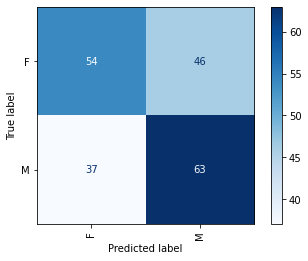

In [6]:
# Trova il modello migliore per validation accuracy
best_val_model = max(results, key=lambda x: x["val_acc"])

# Estrai i dettagli del modello migliore
best_ngram = best_val_model["ngram"]
best_representation = best_val_model["representation"]
best_test_predictions = best_val_model["test_predictions"]
best_test_labels = best_val_model["test_labels"]

print("\n Best model basato sulla Validation Accuracy:")
print(f"N-grammi: {best_ngram}, utilizzando: {best_representation}")
print("Validation Accuracy:", best_val_model["val_acc"])
print("Test Accuracy:", best_val_model["test_acc"])

# Confusion Matrix e Classification Report per il modello migliore
print("\nClassification Report:")
print(classification_report(best_test_labels, best_test_predictions, zero_division=0))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(
    best_test_labels,
    best_test_predictions,
    xticks_rotation="vertical",
    cmap="Blues"
)
plt.show()


# Plot

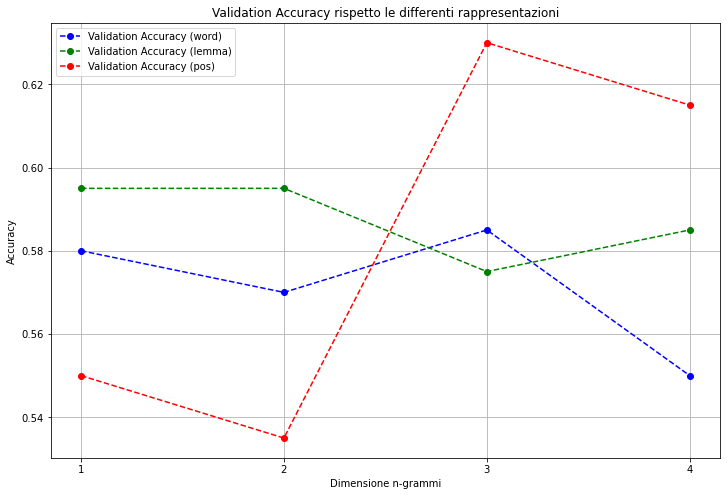

In [7]:
# Trova i risultati per ogni rappresentazione
val_accuracies = {"word": [], "lemma": [], "pos": []}
test_accuracies = {"word": [], "lemma": [], "pos": []}
ngram_sizes = []

for result in results:
    rep = result["representation"]
    ngram_sizes.append(result["ngram"])
    val_accuracies[rep].append(result["val_acc"])
    test_accuracies[rep].append(result["test_acc"])

# Elimina duplicati per i n-gram sizes
ngram_sizes = sorted(list(set(ngram_sizes)))

# Colori per ogni rappresentazione
colors = {"word": "blue", "lemma": "green", "pos": "red"}

# Grafico delle accuracy per il best model
plt.figure(figsize=(12, 8))

for rep in ["word", "lemma", "pos"]:
    plt.plot(
        ngram_sizes,
        val_accuracies[rep],
        label=f"Validation Accuracy ({rep})",
        color=colors[rep],
        linestyle="--",
        marker="o"
    )
   

plt.title("Validation Accuracy rispetto le differenti rappresentazioni")
plt.xlabel("Dimensione n-grammi")
plt.ylabel("Accuracy")
plt.xticks(ngram_sizes)
plt.legend()
plt.grid(True)
plt.show()
